In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math

In [2]:
# This file is the solution to task 2.5, using a UNET-transformer.
# It should be noted that the code is heavily inspired by https://levelup.gitconnected.com/building-stable-diffusion-from-scratch-using-python-f3ebc8c42da3

In [3]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):

    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)

In [14]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [6]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):

    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

In [7]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                            marginal_prob_std,
                            diffusion_coeff,
                            batch_size=64,
                            x_shape=(1, 28, 28),
                            num_steps=num_steps,
                            device='cuda',
                            eps=1e-3, y=None):

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [8]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        
        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim):

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [10]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):

        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [11]:
class UNet_Tranformer(nn.Module):

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                  text_dim=256, nClass=10):
        
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, bias=False)
        self.linear1 = nn.Linear(embed_dim, 32)
        self.gnorm1 = nn.GroupNorm(4, num_channels=32)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
        self.linear2 = nn.Linear(embed_dim, 64)
        self.gnorm2 = nn.GroupNorm(32, num_channels=64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
        self.linear3 = nn.Linear(embed_dim, 128)
        self.gnorm3 = nn.GroupNorm(32, num_channels=128)
        self.attn3 = SpatialTransformer(128, text_dim)

        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, bias=False)
        self.linear4 = nn.Linear(embed_dim, 256)
        self.gnorm4 = nn.GroupNorm(32, num_channels=256)
        self.attn4 = SpatialTransformer(256, text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(256, 128, 3, stride=2, bias=False)
        self.linear5 = nn.Linear(embed_dim, 128)
        self.tgnorm4 = nn.GroupNorm(32, num_channels=128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, bias=False, output_padding=1)
        self.linear6 = nn.Linear(embed_dim, 64)
        self.tgnorm3 = nn.GroupNorm(32, num_channels=64)

        self.tconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, bias=False, output_padding=1)
        self.linear7 = nn.Linear(embed_dim, 32)
        self.tgnorm2 = nn.GroupNorm(32, num_channels=32)
        self.tconv1 = nn.ConvTranspose2d(32, 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.linear1(embed)[..., None, None]
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.linear2(embed)[..., None, None]
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.linear3(embed)[..., None, None]
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.linear4(embed)[..., None, None]
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.linear5(embed)[..., None, None]
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.linear6(embed)[..., None, None]
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.linear7(embed)[..., None, None]
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [12]:
# Specify whether to continue training or initialize a new model

continue_training = False # Either True or False

if not continue_training:

    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))



for epoch in range(n_epochs):
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for batch, (x, y) in enumerate(data_loader):
        x = x.to(device)

        # Compute the loss using the conditional score-based model
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

C:\Users\Matti\AppData\Local\Temp\ipykernel_243288\388195751.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 921.132739 lr 9.8e-04
1 Average Loss: 249.098808 lr 9.6e-04
2 Average Loss: 156.827008 lr 9.4e-04
3 Average Loss: 115.033009 lr 9.2e-04
4 Average Loss: 91.327306 lr 9.0e-04
5 Average Loss: 77.146447 lr 8.9e-04
6 Average Loss: 67.915025 lr 8.7e-04
7 Average Loss: 60.643593 lr 8.5e-04
8 Average Loss: 55.902724 lr 8.3e-04
9 Average Loss: 51.556957 lr 8.2e-04
10 Average Loss: 48.453371 lr 8.0e-04
11 Average Loss: 45.827486 lr 7.8e-04
12 Average Loss: 44.220494 lr 7.7e-04
13 Average Loss: 41.493853 lr 7.5e-04
14 Average Loss: 40.757898 lr 7.4e-04
15 Average Loss: 39.410118 lr 7.2e-04
16 Average Loss: 38.441495 lr 7.1e-04
17 Average Loss: 37.374349 lr 7.0e-04
18 Average Loss: 36.687423 lr 6.8e-04
19 Average Loss: 35.477842 lr 6.7e-04
20 Average Loss: 35.005026 lr 6.5e-04
21 Average Loss: 34.133184 lr 6.4e-04
22 Average Loss: 33.734289 lr 6.3e-04
23 Average Loss: 33.042983 lr 6.2e-04
24 Average Loss: 32.856417 lr 6.0e-04
25 Average Loss: 32.011893 lr 5.9e-04
26 Average Loss: 3

C:\Users\Matti\AppData\Local\Temp\ipykernel_243288\3589533698.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\Matti\AppData\Local\Temp\ipykernel_243288\3589533698.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


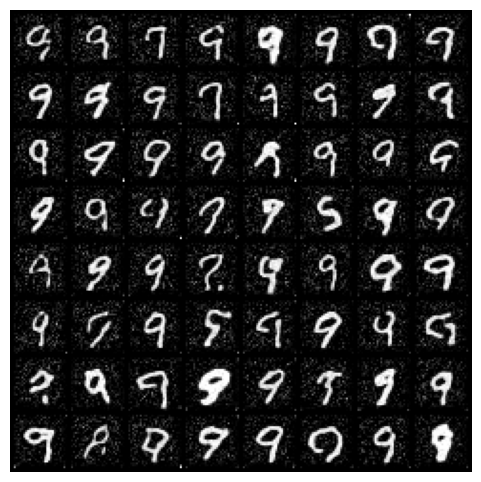

In [15]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)

########### Specify the digit for which to generate samples
###########
digit = 9 #@param {'type':'integer'}
###########
###########

# Set the batch size for generating samples
sample_batch_size = 64 #@param {'type':'integer'}
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250 #@param {'type':'integer'}
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()